In [2]:
import numpy as np
import pandas as pd
from scipy.stats import skewnorm
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

def sigma(x):
    return 1 / (1 + np.exp(-x))

def sigma_inv(x):
    return np.log(x / (1 - x))

#### Worse scanario search

In [3]:
import numpy as np
import pandas as pd
from scipy.special import expit
from scipy.optimize import curve_fit, minimize_scalar
import matplotlib.pyplot as plt

# seeds
np.random.seed(0)

X1s = np.random.normal(1.5, 5, 1000)
X1s = np.sort(X1s)


##### 1. Normal Covariates

In [4]:
def compute_mse_for_scale(scale, n=10000):
    mean_probs_list = []

    for mu in X1s:
        var = np.random.normal(0, scale, n)
        logits = mu + var
        probs = expit(logits)
        mean_probs_list.append(np.mean(probs))

    mean_probs_array = np.array(mean_probs_list)

    # Fit sigmoid with both slope and intercept
    def scaled_sigmoid(x1, a, b):
        return expit(a * x1 + b)

    popt, _ = curve_fit(scaled_sigmoid, X1s, mean_probs_array, p0=[1, 0])
    a_opt, b_opt = popt

    predicted_probs = expit(a_opt * X1s + b_opt)
    mse = np.mean((mean_probs_array - predicted_probs) ** 2)
    return mse * 100000

compute_mse_for_scale(1.5)

1.9308506135156824

In [5]:
result = minimize_scalar(
    lambda s: -compute_mse_for_scale(s, n=25000),
    bounds=(0.01, 15),  # or wider/narrower depending on your use case
    method='bounded'
)

best_scale = result.x
max_mse = -result.fun

print(f"Best scale (maximizing MSE): {best_scale:.4f}")
print(f"Maximum MSE: {max_mse:.6f}")


Best scale (maximizing MSE): 3.8312
Maximum MSE: 3.852974


In [6]:
# scales = np.linspace(0.1, 20, 25)
# mses = [compute_mse_for_scale(s, n=10000) for s in scales]

# plt.plot(scales, mses, marker='o')
# plt.xlabel("Scale of x2")
# plt.ylabel("MSE of best sigmoid fit")
# # vertical line at best_scale
# plt.axvline(x=best_scale, color='red', linestyle='--', label=f"Best scale: {best_scale:.4f}")
# plt.title("Nonlinearity of E[sigma(x1 + x2)] vs. scale of x2")
# plt.grid(True)
# plt.show()


In [7]:
## 2. For a range of x1 values, calculate both E(sigma(x1 + x2)) and sigma(E(x1 + x2)):

scale = best_scale

results = pd.DataFrame(columns=["mu", "mean_probs", "sigma_mean"], index=X1s)

for mu in X1s:

    var = np.random.normal(0,scale,200000)

    logits = mu + np.array(var).reshape(-1,1)
    probs = sigma(logits)

    mean_probs = np.mean(probs)

    sigma_mean = sigma(mu)

    results.loc[mu] = [mu, mean_probs, sigma_mean]

E[sigma(X)]:  0.6924753763737647
Sigma(E[X]):  0.8807970779778823


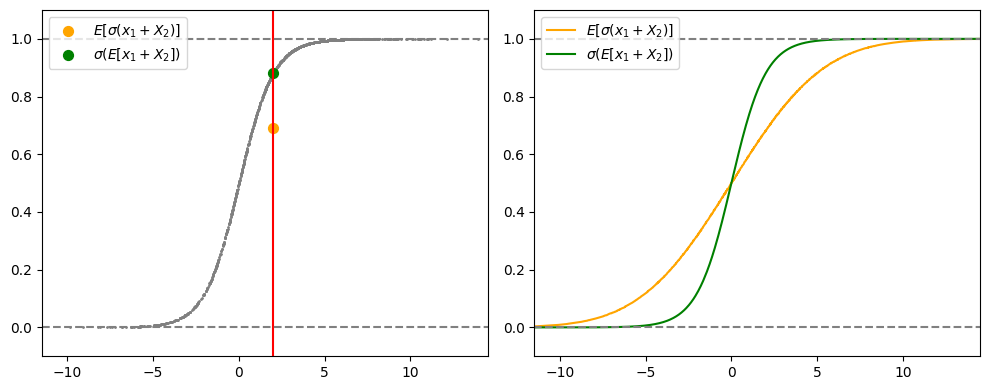

In [8]:
# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# First plot: Scatter plot of logits vs probs
n_samples = 1000
mu = 2
var = np.random.normal(0,best_scale,n_samples)

logits = mu + np.array(var).reshape(-1,1)
probs = sigma(logits)

print("E[sigma(X)]: ", np.mean(probs))
print("Sigma(E[X]): ", sigma(mu))

axes[0].scatter(logits, probs, s=1, color="gray")
axes[0].axvline(x=mu, color='r')
axes[0].scatter(mu, np.mean(probs), color='orange', s=50, marker='o', label=r"$E[\sigma(x_1+X_2)]$")
axes[0].scatter(mu, sigma(mu), color='green', s=50, marker='o', label=r"$\sigma(E[x_1+X_2])$")
axes[0].set_ylim(-0.1,1.1)
axes[0].set_xlim(1.5-13,1.5+13)
axes[0].hlines(0, 1.5-13,1.5+13, color='gray', linestyle='--')
axes[0].hlines(1, 1.5-13,1.5+13, color='gray', linestyle='--')
axes[0].legend()

axes[1].plot(results["mu"], results["mean_probs"], label=r"$E[\sigma(x_1 + X_2)]$", color="orange")
axes[1].plot(results["mu"], results["sigma_mean"], label=r"$\sigma(E[x_1 + X_2])$", color="green")
axes[1].set_ylim(-0.1,1.1)
axes[1].set_xlim(1.5-13,1.5+13)
axes[1].hlines(0, 1.5-13,1.5+13, color='gray', linestyle='--')
axes[1].hlines(1, 1.5-13,1.5+13, color='gray', linestyle='--')
axes[1].legend()

plt.tight_layout()
plt.savefig("data/ExpF/figures/theo_E_sigma.pdf")
plt.show()

R2:  0.98925


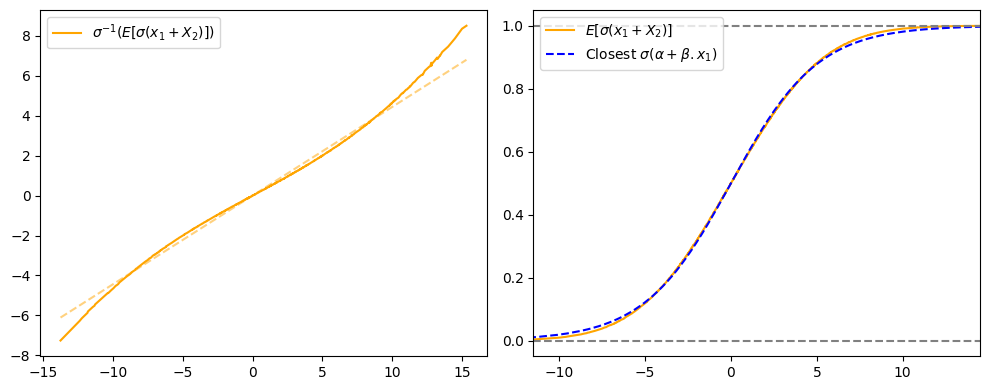

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.special import expit  # expit(x) = sigmoid(x)
from sklearn.linear_model import LinearRegression

results["mu"] = results["mu"].astype(float)
results["mean_probs"] = results["mean_probs"].astype(float)
results["sigma_mean"] = results["sigma_mean"].astype(float)

results["logits_mean_probs"] = np.log(results["mean_probs"] / (1 - results["mean_probs"]))
results["logits_sigma_mean"] = np.log(results["sigma_mean"] / (1 - results["sigma_mean"]))

lr = LinearRegression()
lr.fit(results["mu"].values.reshape(-1, 1), results["logits_mean_probs"])
r2_mean_probs = np.round(lr.score(results["mu"].values.reshape(-1, 1), results["logits_mean_probs"]), 5)
print("R2: ", r2_mean_probs)
preds_probs = lr.predict(results["mu"].values.reshape(-1, 1))

def scaled_sigmoid(mu, a, b):
    return expit(a * mu + b)  # expit is numerically stable sigmoid

# Fit the logistic function to mean_probs
popt, _ = curve_fit(scaled_sigmoid, results["mu"].values, results["mean_probs"].values, p0=[1,0])
a_opt, b_opt = popt[0], popt[1]

# Compute predicted probabilities
probs_LR = expit(a_opt * results["mu"].values + b_opt)

# Create a two-column plot
fig, axes = plt.subplots(1, 2, figsize=(10,4))

# First plot: Logit transformation with linear regression
axes[0].plot(results["mu"], results["logits_mean_probs"], label=r"$\sigma^{-1}(E[\sigma(x_1+X_2)])$", color="orange")
axes[0].plot(results["mu"], preds_probs, color="orange", linestyle="--", alpha=0.5)
# axes[0].plot(results["mu"], results["logits_sigma_mean"], label=r"$\sigma^{-1}(\sigma(E[x_1+X_2]))$", color="g")
axes[0].legend()

# Second plot: Sigmoid fitting
axes[1].plot(results["mu"], results["mean_probs"], label=r"$E[\sigma(x_1+X_2)]$", color="orange")
# axes[1].plot(results["mu"], results["sigma_mean"], label=r"$\sigma(E[x_1+X_2])$", color="g", linestyle="-")
axes[1].plot(results["mu"], probs_LR, label=r"Closest $\sigma(\alpha + \beta . x_1)$", linestyle="--", color="blue")
axes[1].ylim = (-0.1, 1.1)
axes[1].set_xlim(1.5-13,1.5+13)
axes[1].hlines(0, 1.5-13,1.5+13, color='gray', linestyle='--')
axes[1].hlines(1, 1.5-13,1.5+13, color='gray', linestyle='--')
axes[1].legend()

plt.tight_layout()
plt.savefig("data/ExpF/figures/theo_2.pdf")
plt.show()


##### 2. Exponential covariates

In [10]:

def compute_mse_for_scale(scale, n=10000):
    mean_probs_list = []

    for mu in X1s:
        var = np.random.exponential(scale, n) - scale
        logits = mu + var
        probs = expit(logits)
        mean_probs_list.append(np.mean(probs))

    mean_probs_array = np.array(mean_probs_list)

    # Fit sigmoid with both slope and intercept
    def scaled_sigmoid(mu, a, b):
        return expit(a * mu + b)

    popt, _ = curve_fit(scaled_sigmoid, X1s, mean_probs_array, p0=[1, 0])
    a_opt, b_opt = popt

    predicted_probs = expit(a_opt * X1s + b_opt)
    mse = np.mean((mean_probs_array - predicted_probs) ** 2)
    return mse * 100000

compute_mse_for_scale(1.5)

11.270314248473609

In [11]:
result = minimize_scalar(
    lambda s: -compute_mse_for_scale(s, n=25000),
    bounds=(0.01, 15),
    method='bounded'
)

best_scale = result.x
max_mse = -result.fun

print(f"Best scale (maximizing MSE): {best_scale:.4f}")
print(f"Maximum MSE: {max_mse:.6f}")

Best scale (maximizing MSE): 7.6275
Maximum MSE: 179.629107


In [12]:
# scales = np.linspace(0.1, 20, 25)
# mses = [compute_mse_for_scale(s, n=10000) for s in scales]

# plt.plot(scales, mses, marker='o')
# plt.xlabel("Scale of x2")
# plt.ylabel("MSE of best sigmoid fit")
# # vertical line at best_scale
# plt.axvline(x=best_scale, color='red', linestyle='--', label=f"Best scale: {best_scale:.4f}")
# plt.title("Nonlinearity of E[sigma(x1 + x2)] vs. scale of x2")
# plt.grid(True)
# plt.show()


In [13]:
results = pd.DataFrame(columns=["mu", "mean_probs", "sigma_mean"], index=X1s)

for mu in X1s:

    draws = np.random.exponential(best_scale, 100000) - best_scale 
    var = draws - np.mean(draws)

    logits = mu + np.array(var).reshape(-1,1)
    probs = sigma(logits)

    mean_probs = np.mean(probs)

    sigma_mean = sigma(mu)

    results.loc[mu] = [mu, mean_probs, sigma_mean]

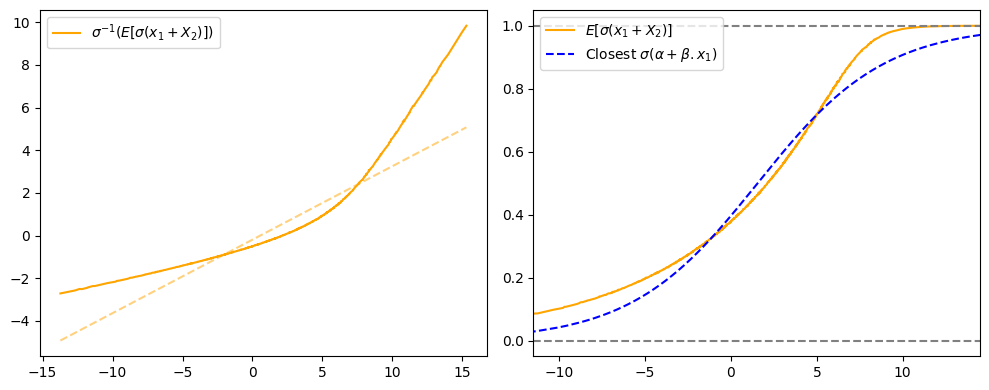

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.special import expit  # expit(x) = sigmoid(x)
from sklearn.linear_model import LinearRegression

results["mu"] = results["mu"].astype(float)
results["mean_probs"] = results["mean_probs"].astype(float)
results["sigma_mean"] = results["sigma_mean"].astype(float)

results["logits_mean_probs"] = np.log(results["mean_probs"] / (1 - results["mean_probs"]))
results["logits_sigma_mean"] = np.log(results["sigma_mean"] / (1 - results["sigma_mean"]))

lr = LinearRegression()
lr.fit(results["mu"].values.reshape(-1, 1), results["logits_mean_probs"])
r2_mean_probs = np.round(lr.score(results["mu"].values.reshape(-1, 1), results["logits_mean_probs"]), 5)
preds_probs = lr.predict(results["mu"].values.reshape(-1, 1))

def scaled_sigmoid(mu, a, b):
    return expit(a * mu + b)  # expit is numerically stable sigmoid

# Fit the logistic function to mean_probs
popt, _ = curve_fit(scaled_sigmoid, results["mu"].values, results["mean_probs"].values, p0=[1,0])
a_opt, b_opt = popt[0], popt[1]

# Compute predicted probabilities
probs_LR = expit(a_opt * results["mu"].values + b_opt)

# Create a two-column plot
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# First plot: Logit transformation with linear regression
axes[0].plot(results["mu"], results["logits_mean_probs"], label=r"$\sigma^{-1}(E[\sigma(x_1+X_2)])$", color="orange")
axes[0].plot(results["mu"], preds_probs, color="orange", linestyle="--", alpha=0.5)
# axes[0].plot(results["mu"], results["logits_sigma_mean"], label=r"$\sigma^{-1}(\sigma(E[x_1+X_2]))$", color="g")
axes[0].legend()

# Second plot: Sigmoid fitting
axes[1].plot(results["mu"], results["mean_probs"], label=r"$E[\sigma(x_1+X_2)]$", color="orange")
# axes[1].plot(results["mu"], results["sigma_mean"], label=r"$\sigma(E[x_1+X_2])$", color="g", linestyle="-")
axes[1].plot(results["mu"], probs_LR, label=r"Closest $\sigma(\alpha + \beta . x_1)$", linestyle="--", color="blue")
axes[1].ylim = (-0.1, 1.1)
axes[1].set_xlim(1.5-13,1.5+13)
axes[1].hlines(0, 1.5-13,1.5+13, color='gray', linestyle='--')
axes[1].hlines(1, 1.5-13,1.5+13, color='gray', linestyle='--')
axes[1].legend()

plt.tight_layout()
plt.savefig("data/ExpF/figures/theo_3.pdf")
plt.show()
